In [1]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)


In [2]:
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [4]:
original_data = pd.read_csv('data_aa/aa_rpoB.csv', header=None)
original_featrues = pd.read_csv('data_aa/RIF_MIC.csv', header=None)

# Data

In [5]:
data = original_data

target = original_featrues

train_data_index = np.random.choice(data.shape[0], size=int(data.shape[0]*0.8), replace=False)
all_indices = np.arange(data.shape[0])
test_data_index = np.setdiff1d(all_indices, train_data_index)

train_data = data.iloc[train_data_index,:]
train_target = target.iloc[train_data_index,:]
train_data = train_data.reset_index(drop=True)
train_target = train_target.reset_index(drop=True)
#don't touch test data, split out validation data from training data during training
test_data = data.iloc[test_data_index,:]
test_target = target.iloc[test_data_index,:]
test_data = test_data.reset_index(drop=True)
test_target = test_target.reset_index(drop=True)

In [6]:
na_indices = train_target[train_target.isna().any(axis=1)].index
train_data.drop(na_indices, inplace=True)
train_target.drop(na_indices, inplace=True)

# RandomforestRegressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import pandas as pd

# Assuming `df` is your DataFrame
# and it contains the target variable in a column named 'target'

# Separate features and target
X = train_data  # Features
y = train_target  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Calculate the Mean Squared Error (MSE) or another appropriate metric for regression
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming `train_data` and `train_target` are defined
X = train_data  # Features
y = train_target  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],  # List of numbers of trees
#     'max_depth': [None, 10, 20, 30]  # Maximum depth of the trees, including 'None' for unlimited depth
# }

param_grid = {
    'n_estimators': [300,400,500],  # List of numbers of trees
    'max_depth': [30,40,50,60]  # Maximum depth of the trees, including 'None' for unlimited depth
}

# Initialize the RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=300; total time=  17.8s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=300; total time=  18.1s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=300; total time=  18.2s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=300; total time=  19.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=300; total time=  18.2s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=400; total time=  23.4s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=400; total time=  23.8s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=400; total time=  24.4s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=400; total time=  25.5s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=400; total time=  24.2s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=500; total time=  29.3s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=500; total time=  30.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=500; total time=  30.4s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=500; total time=  31.7s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=30, n_estimators=500; total time=  30.3s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=300; total time=  20.9s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=300; total time=  21.4s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=300; total time=  21.6s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=300; total time=  22.7s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=300; total time=  23.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=400; total time=  28.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=400; total time=  28.2s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=400; total time=  28.6s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=400; total time=  29.7s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=400; total time=  28.3s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=500; total time=  34.5s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=500; total time=  34.9s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=500; total time=  35.5s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=500; total time=  37.2s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=40, n_estimators=500; total time=  35.5s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=300; total time=  23.4s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=300; total time=  23.6s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=300; total time=  24.1s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=300; total time=  25.3s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=300; total time=  24.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=400; total time=  31.2s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=400; total time=  31.4s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=400; total time=  32.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=400; total time=  33.7s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=400; total time=  32.3s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=500; total time=  39.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=500; total time=  39.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=500; total time=  39.5s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=500; total time=  42.1s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=50, n_estimators=500; total time=  39.8s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=300; total time=  25.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=300; total time=  25.2s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=300; total time=  25.5s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=300; total time=  27.1s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=300; total time=  25.7s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=400; total time=  33.3s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=400; total time=  33.6s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=400; total time=  34.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=400; total time=  36.1s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=400; total time=  34.2s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=500; total time=  41.6s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=500; total time=  42.0s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=500; total time=  42.5s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=500; total time=  45.2s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=60, n_estimators=500; total time=  42.8s


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters found:  {'max_depth': 40, 'n_estimators': 300}
Mean Squared Error: 9.374878024921


# LazyPredict

In [64]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming `train_data` and `train_target` are your features and target variable respectively
X = train_data
y = train_target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and compare all models
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Display the results
print(models)


 98%|█████████▊| 41/42 [4:02:39<02:56, 176.57s/it]    

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 7504, number of used features: 28
[LightGBM] [Info] Start training from score 4.002683


100%|██████████| 42/42 [4:02:40<00:00, 346.68s/it]

                                           Adjusted R-Squared  \
Model                                                           
XGBRegressor                                             0.50   
LassoCV                                                  0.50   
ElasticNetCV                                             0.50   
LassoLarsCV                                              0.50   
LarsCV                                                   0.50   
OrthogonalMatchingPursuit                                0.50   
LassoLarsIC                                              0.49   
OrthogonalMatchingPursuitCV                              0.49   
BayesianRidge                                            0.49   
RidgeCV                                                  0.49   
Ridge                                                    0.49   
GradientBoostingRegressor                                0.48   
MLPRegressor                                             0.47   
RandomForestRegressor    

# Xgboost

In [7]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,859,860,861,862,863,864,865,866,867,868
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9531,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9533,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
X

,0,1,2,3,4,5,6,7,8,9,...,859,860,861,862,863,864,865,866,867,868
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9531,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9533,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# fit model no training data
# evaluate an xgboost regression model on the housing dataset
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

# load the dataset
X = train_data
y = train_target# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X, y)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 1.688 (0.068)


In [30]:
import numpy as np

# Assuming model.feature_importances_ are defined and X.columns contains feature names
feature_importances = model.feature_importances_
features = X.columns

# Create an array of indices sorted by the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Order the feature importances from largest to smallest
ordered_importances = feature_importances[sorted_indices]

# Order the feature names (index) in the same order as the sorted importances
ordered_features = features[sorted_indices]

# Now, ordered_importances contains the feature importances in descending order,
# and ordered_features contains the corresponding feature names in the same order.


In [39]:
SNP = np.array(['309C>T', '1482G>A', 'Ser450Leu',
       'Glu250Gly', 'Asp435Val', 'Ser450Phe',
       'Thr400Ala', 'His445Tyr', '-61C>T',
       'Val359Ala', '1683G>A', '684C>T',
       'Ile751Val', 'Lys944Asn', '-113C>T',
       'His445Leu', 'His445Asp', 'Lys891Glu',
       'Asp435Tyr', 'Gln432Lys', 'Glu761Asp',
       'Val695Leu', 'His445Arg', 'Arg827Leu',
       '1299C>T', 'Ala286Val', '1297_1299dupTTC',
       'Leu449Met', 'Leu554Pro', '138A>C',
       'Leu430Pro', 'Arg552His', '1292_1294dupGCC',
       'Asp634Gly', '1410C>T', '-49C>T',
       'Ile488Val', 'Asp531Glu', 'Thr399Ile',
       'Pro768Leu', 'Leu452Pro', '2025C>A',
       'His445Asn', 'Arg219Cys', '1659G>A',
       '1300_1305delATGGAC', 'Gly46Val', '300G>A',
       'Pro45Ser', 'Asp435Phe', 'Ala692Thr',
       '-199C>T', '1788C>T', 'Ser450Met',
       'Gln409Arg', 'Pro802Arg', 'His445Cys',
       'Pro45Leu', '-6T>C', 'Met434Ile',
       '2058G>A', '-134T>G', 'Pro45Thr',
       'Gln432Pro', '1853delC', 'Cys116Phe',
       'Thr756Ala', 'Leu731Pro', '-80A>G',
       'Gly28Val', 'Gly95Trp', 'Arg827Cys',
       '-169T>C', 'Asp435Asn', '2361T>C',
       'Val170Ala', 'Phe1062Cys', 'Asp435Gly',
       'Ile1106Thr', 'Ser450Trp', 'Asp103Glu',
       'Met601Ile', 'Val970Met', 'Phe669Leu',
       '375T>C', '378A>G', '387C>G', '390C>G',
       'Asn539Lys', '-83A>G', 'Ile491Phe',
       '-187A>C', 'Gly46Arg', 'Tyr308Asp',
       'Tyr474His', 'Met434Lys', '204C>T',
       'Glu291*', 'Phe1013Leu', '1116G>C',
       '1236C>A', 'Gln436Arg', 'Ser431Arg',
       'Phe503Ser', 'Ile491Thr', 'Val496Met',
       'Tyr1015Cys', 'Gln975His', 'Asp265Gly',
       'His674Arg', 'Ser22Thr', 'Glu639Gly',
       'Leu48Phe', 'Asp545Glu', '-13G>A',
       'Gln1080Arg', 'His835Arg', 'Val113Ile',
       'His445Gly', 'Arg827His', '2031C>T',
       'Thr427Ala', '1884G>C', '1312_1314delAAC',
       'Glu1011Ala', 'Val357Leu', 'Met587Ile',
       'Met121Ile', 'Ile491Leu', '-137C>T',
       'Ser672Pro', 'Pro152Leu', 'Ala686Thr',
       '-192A>C', '-173A>T', 'Val262Gly',
       '2065C>A', 'Asp897Gly', 'Leu1030Arg',
       'Arg167Cys', 'Gln432Leu', 'His445Gln',
       '114G>A', '801G>A', 'Ala934Thr',
       'Leu778Val', 'Glu821Val', 'Ala451Val',
       'Gln432Glu', 'Glu481Ala', 'Arg791Cys',
       'Ile480Val', 'Ala951Asp', 'Asp574Glu',
       'Asp571Ala', 'Val305Ile', 'Val562Ala',
       'Val170Phe', 'Leu430Arg', 'Glu207Lys',
       'Val833Met', 'Ser441Leu', 'Lys446Arg',
       'Ser428Gly', 'Glu320Asp', 'Lys944Thr',
       '-115delT', 'Thr52Pro', 'His445Ser',
       'Asp92Gly', 'Asn437Ser', 'Ser582Ala',
       'Ser428Thr', 'Phe151Leu', 'Pro454Leu',
       'Asn437Ile', 'Thr400Asn', 'Ser874Tyr',
       'Leu778Met', 'Asn437Asp', 'Gly79Ser',
       '231G>A', '1182C>G', 'Ala527Val',
       '-110A>G', 'Ile491Val', 'Val496Ala',
       'Gln429Leu', '1173G>A', 'Gly1000Cys',
       '336C>T', '2238C>T', '1698C>A',
       '1725C>A', 'Tyr564His', 'Thr288Lys',
       'Leu327Pro', 'Ile480Thr', 'Phe424Val',
       'Thr159Pro', 'His723Asp', 'Ile59Asn',
       'Arg552Leu', 'Met390Thr', 'His1028Tyr',
       'Asn381Thr', 'Glu750Gly', '-159C>T',
       'Ser254Pro', 'Val1101Ala', 'Ser98Ala',
       'Asp435His', '1401C>A', 'Pro768Gln',
       'Gly633Asp', '12C>T', 'Ser195Arg',
       'Met1070Thr', 'Glu550Gly', 'His445Pro',
       'Lys446Gln', '1332C>G', 'Leu452Arg',
       'Ile491Met', 'Asp435Leu', '1155C>G',
       'Gln401Arg', 'Ile90Leu', 'Met434Val',
       'Gln1056Arg', '1980C>T', 'His749Tyr',
       'Val534Met', 'Val970Ala', '1242C>T',
       'Glu156Gly', 'Ala538Pro', 'Asp543Gly',
       'Gln432His', 'Ser188Phe',
       '1279_1284delACCAGC', 'Pro45Ala', 'Leu378Arg',
       'Gln1060His', '1572C>T', 'Thr410Arg',
       'Ala1075Thr', 'Leu1149Gln', 'Arg219Leu',
       '-122C>T', 'Pro483Ser', 'Thr676Pro',
       'Ile925Val', '1254C>T', 'Gln429Pro',
       'Ile488Leu', 'Lys110Arg', '2004G>A',
       'Ile588Val', 'His343Gln', 'Asp53Val',
       'Cys681Arg', 'Pro416Ala', 'Thr482Ile',
       'Ala753Thr', 'Thr350Ile', 'Ser388Leu',
       'Glu639Asp', 'Ala584Gly', 'Phe424Leu',
       'Pro45Arg', 'Gln172Arg', 'Lys891Arg',
       'Ile892Phe', 'Ile910Val', 'Gly945Glu',
       'Leu127Met', 'Asn136Lys', 'Ala753Val',
       'Asp108Glu', 'Glu1150Asp', 'Thr676Ile',
       'Pro15Leu', '1017G>C', 'His343Tyr',
       '1323G>T', '1365C>T', 'Ser458Thr',
       'Glu460Asp', '1383T>C', '1389G>C',
       '1392G>C', '1413G>C', '1428G>C',
       '1437G>A', '1539G>A', 'Met605Thr',
       '1869G>T', 'Met898Ile', '1524G>T',
       '1884G>A', 'Arg1008Cys', 'Val1131Glu',
       'Ser450Val', 'Asn163Lys', '-169_-168insA',
       '12C>A', 'Glu86Asp', 'Gln537*',
       'Cys701Tyr', 'Gly722Cys', 'Ala942Thr',
       '-152C>T', 'Gly675Asp', 'Ser493Leu',
       'Pro27Thr', 'Asp766His', '183G>T',
       '834C>T', 'Lys1054Arg', 'Tyr308Cys',
       '2136C>T', '423C>T', 'Ser428Arg',
       '798G>A', '855A>C', '1608A>G',
       'Arg222His', '942C>G', '1179G>A',
       '1623G>A', 'Arg627His', '2109C>T',
       'Val736Leu', 'Gln869Pro', 'Ile873Phe',
       '-54C>A', 'Arg224Cys', 'Thr676Ala',
       'Ala599Thr', 'Thr399Pro', 'Asp301Asn',
       'Met1070Ile', 'Phe424Cys', 'Glu356*',
       '495C>T', 'Thr444Ile', 'Glu460Gly',
       'Asn1155Ser', '210G>A', 'Tyr564Cys',
       'Asp435Ser', '703C>T', 'Thr508Ala',
       'Gln429His', 'Ser450Ala', 'Glu738Ala',
       'Glu706Lys', '-38G>A', '15C>A',
       'Ile922Asn', '-131A>C', 'Val496Leu',
       'Val518Ile', 'Ser1009Ile', 'Ala960Glu',
       'Gly442Glu', '2175C>T', '2406G>A',
       'Asp435Ala', 'Ile491Ser', 'Gly642Ser',
       '804_805delGT', '30C>G', '-173A>G',
       '-26C>T', 'Phe971Leu', 'Val216Ile',
       'Ile1106Met', '705G>A', 'Arg225Gly',
       'Ser450Gly', 'Gln51Pro', 'Ile162Val',
       '1839C>G', '1941G>C', 'Ala977Asp',
       '36T>C', 'Val50Ala', '2553C>T',
       'Glu1150Lys', 'His1028Arg', 'Glu807Gly',
       '-21G>C', 'Gly463Trp', 'Gln226His',
       'Asn260Asp', 'His914Tyr', 'Glu1066Ala',
       'Lys832Glu', 'Ser1134Arg', 'Pro439Leu',
       'Lys274Asn', '606C>T', 'Leu758Pro',
       'Pro856Leu', 'Lys944Glu', 'Thr968Lys',
       '1306_1308delCAG', 'Ile491Tyr', 'Arg225Pro',
       '-46C>G', '2427G>C', 'Arg552Cys',
       '-161G>A', 'Val583Met', 'Asn24Lys',
       'Ser102Pro', 'Pro1014Arg', '702G>A',
       'Ala943Thr', 'Gly884Ala', 'Gly973Asp',
       'Met587Thr', 'Arg224His', '708C>T',
       'Val44Gly', 'Ile744Thr', 'Thr361Asn',
       'Ile406Phe', 'Leu42Val', 'Asn437His',
       'Asp520Ala', 'Asp515Tyr', '-123G>T',
       '1806G>A', 'Val33Leu', 'Asp435Glu',
       '108T>C', 'Asp631Gly', 'Leu80Met',
       'Phe133Leu', 'Arg32Leu', 'Ala1055Pro',
       'Asn487Ser', 'Gln980His', 'Ala584Asp',
       '279C>T', 'Arg734His', 'Gly376Val',
       'Arg824His', 'Asp545His', 'Val50Leu',
       'Lys886Glu', '2058G>C', 'Val534Gly',
       'Val394Leu', 'Asp1033Glu', '96G>T',
       'Lys37Asn', '201C>G', '2364C>G',
       '2361T>G', 'Pro280Leu', '-87C>T',
       '1025delT', '-56G>T', 'Glu738*',
       'Ala628Glu', 'His445Phe', 'Leu235Met',
       'Glu240Gly', '-190C>T', 'His674Asp',
       'Ser441Gln', '1291_1302delAGCCAATTCATG',
       'Val129Gly', 'Arg224Leu', '-53A>T',
       '-25G>A', 'Arg448Gln', '213G>A',
       '2427G>A', 'Ser441Ala', '-62C>T',
       'Pro27Leu', 'Arg824Cys', 'Asp531Gly',
       '691C>T', '1059C>T', 'Thr660Asn',
       '2184G>C', 'His445Val', 'Phe433Leu',
       '1290_1298delGAGCCAATT', 'Pro577Ala',
       'Ser441Val', 'Val1094Asp', 'Lys822Thr',
       'Val168Ala', 'Glu639Lys', '-159_-158insT',
       'Arg871Leu', 'Ala599Val', 'His674Tyr',
       'Val867Met', 'Asp214Asn', 'Phe433Ser',
       'Arg1162Ser', 'Gly836Cys', 'Met477Arg',
       'Pro104His', 'Gly453Ala', 'Leu525Pro',
       'Arg781Trp', '390C>T', '-160T>C',
       'Ala670Thr', 'Glu978Lys', 'Val168Gly',
       'His835Gln', 'Glu592Asp', 'Gly60Arg',
       '2158_2159delTG', '1294_1296delCAA',
       '-180A>C', 'Ser34Pro', 'Ser239Asn',
       '726T>C', '735G>C', 'Phe246Leu',
       'Asp259His', '780C>T', '802C>T',
       '805T>C', '828T>C', '840C>G', '849A>G',
       'Asp402Glu', 'His445*', '1497G>C',
       '1512G>T', '1521A>G', '1527G>T',
       '1533C>G', 'Gly516Cys', '1944G>A',
       '2352G>C', '2370T>C', '2379G>C',
       '2388G>C', '2430G>C', 'His883Gln',
       'Gly890Cys', 'Lys446Glu', 'Pro177Ala',
       'Ser441Met', '1921delA', 'Pro177Ser',
       'Gly1092Cys', '-70C>T', '865C>T',
       'Leu778Gln', 'His593Tyr', '-66C>T',
       'Thr9Ile', 'Asp265Glu', 'Glu563Ala',
       'Pro700Leu', 'Ser441Trp', 'His533Asn',
       'Ser493Arg', 'Lys891Thr', 'Ser176Leu',
       '-70C>A', 'Pro454His', 'Leu775Pro',
       '396G>A', '1326G>T', 'Arg167His',
       '1725C>T', 'Ser493Thr', '39_44dupTAGTCC',
       '1281C>T', 'Leu709Gln', 'Asn989Asp',
       'Lys37Arg', 'Tyr510His', 'Ala1153Val',
       'Glu896Lys', '1510_1512dupGGG', 'Ala902Pro',
       'Glu721Asp', 'Val351Ala', '1056G>C',
       'Glu360Asp', 'Thr361Ala', '2208C>G',
       '2232C>T', '-88C>T', 'Leu1132Val',
       '1893C>T', '-195C>A', 'Gly836Ser',
       '-154C>A', 'Thr159Lys', 'Ala960Pro',
       'Tyr1097Cys', '3305delA', 'Met573Thr',
       'His674Gln', '-132T>C', 'Phe1115Leu',
       '1443A>G', 'Leu452Val', 'Ala951Thr',
       'Arg607Ser', '939G>A', '1353G>A',
       'Asn597Ile', 'Pro719Thr', 'Ala964Thr',
       '-112G>A', 'Thr444Ser', 'Val355Ile',
       'Pro682Ala', 'Val996Ala', 'Pro502Leu',
       'Cys701Trp', '215delG', 'Thr928Asn',
       '-163T>C', '1829delT', 'Glu465Gln',
       'Thr1084Pro', 'Glu1113Gly',
       '1302_1310delGGACCAGAA', 'Asn163Asp',
       '243A>G', 'Leu490Pro', 'Thr427Gly',
       '1692C>T', 'His366Pro', 'Arg397Gly',
       '1390C>T', 'Asp528His', '1593C>T',
       'Pro589Ala', 'Ala632Asp', 'Gly843Arg',
       'Pro906Ala', '1488G>A', 'Ala638Gly',
       'Ile965Val', '2557_2562dupGACGAG', '84A>T',
       '1297_1305delTTCATGGAC', '2142G>A', '-162A>G',
       'Glu56*', 'Leu48Ile', '870G>A',
       '606C>A', '39T>C', '1500C>T',
       'Thr508Lys', 'Val1131Ala', '495C>G',
       'Gly699Ser', 'Thr742Ala', 'His343Arg',
       'Val198Met', 'Ile542Lys', 'Arg448Lys',
       'Ser96Leu', 'Ser16Cys', 'Thr159Met',
       'Pro177Leu', 'Lys939Gln', 'Ser672Phe',
       '1728G>A', '2484C>T', 'Cys1126Phe',
       '45G>A', 'His1028Asp', 'Leu84Pro',
       'Lys119Asn', '-4C>T', '2247T>C',
       'Arg552Ser', '381G>T', 'Val562Met',
       '1086C>T', 'Gln436Pro', 'Asn487Thr',
       '1557C>T', 'Val800Ala', 'Asn673Ser',
       'Asp1148Glu', '504G>A', '757_758delCG',
       'Ser254Trp', '2439G>C',
       '1303_1317delGACCAGAACAACCCG', '1341C>T',
       '1344A>T', '1359G>C', 'Gly787Arg',
       'Glu896Gly', '1050C>G', 'Val534Leu',
       '1149C>T', 'Ala334Val', '312T>G',
       'Val581Met', 'Ala29Val', 'Arg397Leu',
       '1807dupG', 'Met920Val', '-66_-65insG',
       'Ala131Asp', 'Ser428Ile', 'Met349Lys',
       '1356G>T', '1303_1305delGAC', '-4delC',
       'Thr508Pro', '1569G>C', 'Ser16Asn',
       'Asp186Gly', '-9G>T', '1773G>A',
       '2055C>T', 'Asp792Glu', 'Asp993Asn',
       'Thr1047Ile', 'Ser493Trp', 'Asn438Ser',
       'Thr427Asn', 'Gln436Leu', 'Leu206Ile',
       '1425C>T', '3213_3214delGG', 'Val970Gly',
       '-137C>A', 'Asn963Ser', 'Pro280Ser',
       'Ala708Ser', 'Gly887Ala', 'Ala405Glu',
       'Leu979Met', 'Leu268Arg', 'Met398Thr',
       'Glu484Gly', 'Glu40*', 'Ser450Gln',
       'Leu452Gln', 'Met434Thr', '768G>C',
       '2010C>T', '-141T>C', '1605G>C',
       'Thr427Ile', '-179C>T', 'Phe106Leu',
       '1914C>T', 'Thr1018Lys', 'Pro483Leu',
       'Arg17Cys', '13delC', '1566C>T',
       'Glu811*', 'Asp877His', 'Phe424Gly',
       'Lys512Glu', 'Pro358Leu', 'His674Asn',
       'Phe1005Val', '687C>A', 'Asp993Glu',
       'Leu591Pro', '2627_2629dupGTG', 'Gly915Ser',
       '597C>T', 'Pro988Ala', 'Gly319Asp',
       'Gly79Asp', '231G>T', 'Met655Val',
       'Asp875Glu', 'Ile873Asn', '-184C>A',
       '-182delC', 'Ala29Thr', 'Leu173Pro',
       'Pro454Ser', 'Val636Phe', '132T>A',
       'Asp752Asn', 'Leu957Val', 'Ala498Val',
       'Tyr651His', 'Arg63Ser', 'Ala68Ser',
       '957C>A', 'Ile696Val', 'Thr1090Ala',
       'Val198Glu', 'Ser201Asn', '1923C>T',
       '1296_1307delATTCATGGACCA', 'Pro439Ala',
       '1005C>T', 'Ile1046Val', '2140C>T',
       'His194Tyr', 'Val797Leu', '-77A>G',
       'Ala950Ser', 'Glu978*', 'Pro834Thr',
       '2196C>T', 'Gln961His', '-171C>A',
       'Val613Phe', 'Asn487His', '327C>T',
       'Thr400Ser', '1024T>C', '1035T>C',
       'Thr361Val', '1104C>T', 'Ala617Ser',
       'Pro618Gln', '1983G>T', '2451C>A',
       'Gly881Val', '1327T>C', 'His366Asn',
       'Arg532Leu', '-8G>T', '9T>C',
       '2052G>C', '-180_-179insCTTGACACCGTGGTCTTAGTC',
       'Glu360Gln', '1533C>T', 'Glu1121Asp',
       '1710G>A', 'Gln975Lys', 'Val228Ile',
       'Asp1146Gly', '195C>A', '447T>C',
       'Val534Ala', '255C>T', '-3A>G',
       '-102T>A', 'Gly263Val', 'Asn437Tyr',
       'Ala1166Gly', 'Ser431Gly', '1899C>A',
       'Asp3Gly', 'Cys681Gly', '1284C>T',
       'Val523Leu', 'Asp265Ala', 'Gln537Arg',
       'Pro483Thr'])

In [40]:
ordered_SNP = SNP[sorted_indices]

In [ ]:
ordered_SNP

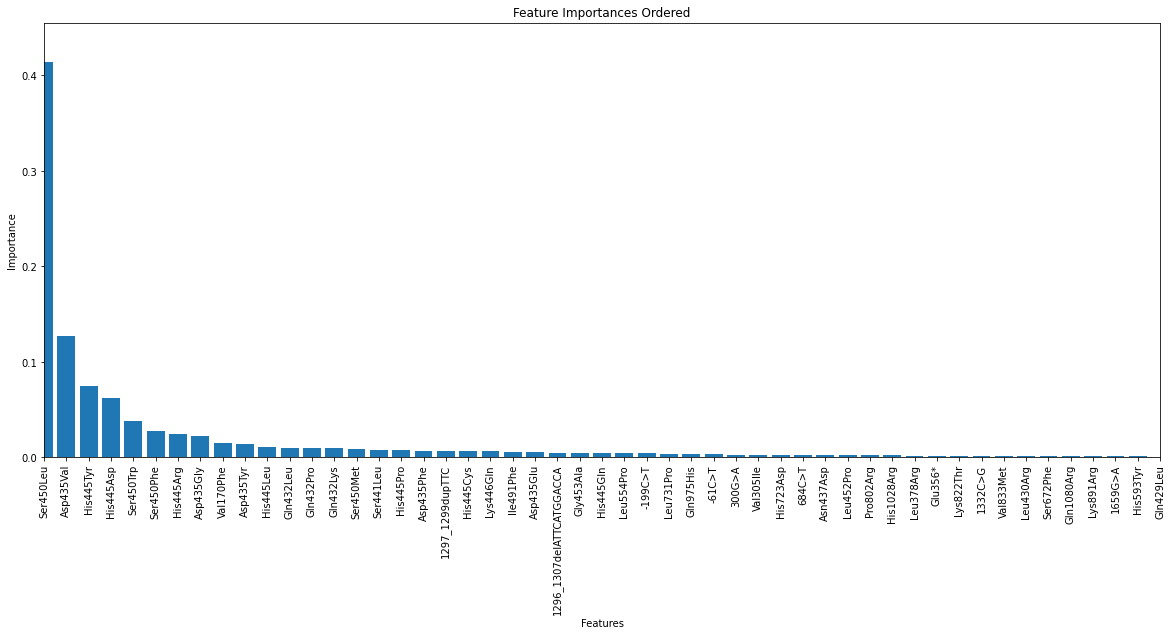

In [46]:
from matplotlib import pyplot as plt

# Make the plot larger
plt.figure(figsize=(20, 8))

# Plot ordered feature importances
plt.bar(range(len(ordered_importances)), ordered_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(ticks=range(len(ordered_SNP)), labels=ordered_SNP, rotation=90)
plt.title('Feature Importances Ordered')
plt.ylim((0,0.5))
plt.xlim((0,50))
# Optionally, change y-axis range to adjust the view
plt.ylim(0, max(ordered_importances) * 1.1)

plt.show()


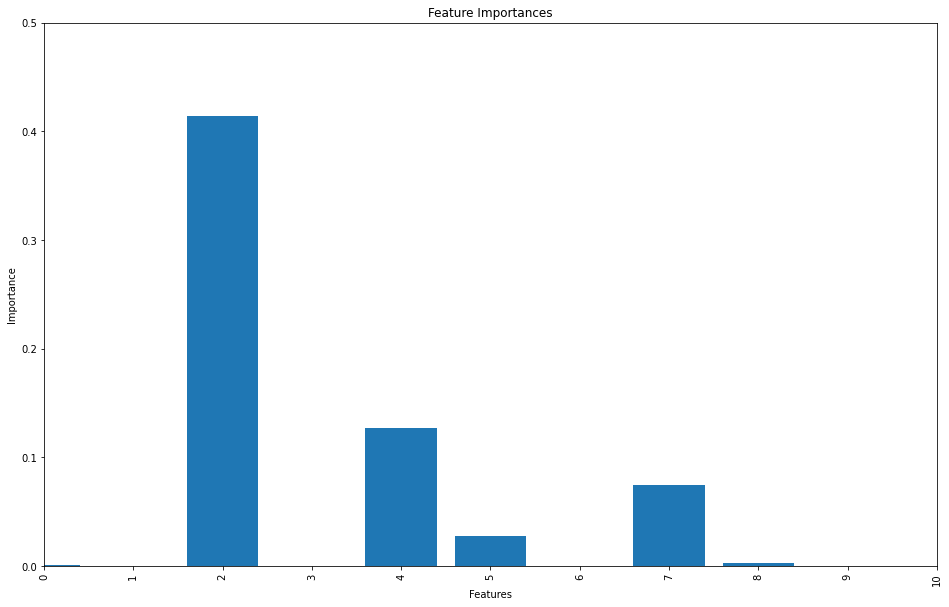

In [28]:
from matplotlib import pyplot as plt

# Get feature importances
feature_importances = model.feature_importances_

# Plot feature importances
plt.figure(figsize=(16, 10))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(ticks=range(len(X.columns)), labels=X.columns, rotation=90)
plt.title('Feature Importances')
plt.ylim((0,0.5))
plt.xlim((0,10))
plt.show()
